# **Importing the libraries**

In [1188]:
import os

# Getting rid of annoying CUDA warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def check_and_install(package_name):
    try:
        __import__(package_name)
    except ImportError:
        os.system(f"pip install {package_name}")

# The other imports
check_and_install('gdown')
import numpy as np
import tensorflow as tf
import PIL.Image
from keras import layers
import pathlib
import shutil
import subprocess

In [1189]:
arrhyth_path = pathlib.Path("arrhythmia_data_root_png_bi")

if not arrhyth_path.exists():
    os.system("gdown 1-skFjlTPuC3QDZXPbrlPkIBZ0gFGFcQ6 -O arrhyth_png_bi.zip")
    os.system("unzip arrhyth_png_bi.zip | head -n 10")

# **Dataset download**

In [1190]:
# !pip install gdown

In [1191]:
# !gdown 1-skFjlTPuC3QDZXPbrlPkIBZ0gFGFcQ6 -O arrhyth_png_bi.zip
# !unzip arrhyth_png_bi.zip | head -n 10

In [1192]:
data_dir = pathlib.Path('arrhythmia_data_root_png_bi')
images = len(list(data_dir.rglob('*.png')))
images

36782

In [1193]:
eletr = list(data_dir.rglob('training_png/class_0_png/*'))
for i in range(5):
    PIL.Image.open(str(eletr[i]))

## Or you could use something like this to download and extract the dataset

In [1194]:
# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
# data_dir = pathlib.Path(archive).with_suffix('')

To list the images

In [1195]:
# To count the images:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

# **Image configs**

In [1196]:
hp = {}
hp['image_size'] = 40 # H x W
hp['num_channels'] = 1 # C
hp['patch_size'] = 4 # Ph x Pw
hp['batch_size'] = 32
hp['num_patches'] = (hp['image_size']**2) // (hp['patch_size']**2) # (H x W) / (Ph x Pw)

# **Dataset preprocessing using `tf.data`**

In [1197]:
# Training set
train_ds = tf.data.Dataset.list_files(str(data_dir/'training_png/*/*'), shuffle=False)
train_ds = train_ds.shuffle(images, reshuffle_each_iteration=False, seed=42)

# Validation set
val_ds = tf.data.Dataset.list_files(str(data_dir/'validation_png/*/*'), shuffle=False)

# Testing set
test_ds = tf.data.Dataset.list_files(str(data_dir/'test_png/*/*'), shuffle=False)

In [1198]:
len(train_ds), len(val_ds), len(test_ds)

(29076, 3849, 3857)

In [1199]:
for f in train_ds.take(5):
  print(f.numpy())

b'arrhythmia_data_root_png_bi/training_png/class_0_png/230_489863_00_class_0.png'
b'arrhythmia_data_root_png_bi/training_png/class_0_png/221_393792_00_class_0.png'
b'arrhythmia_data_root_png_bi/training_png/class_0_png/213_223231_00_class_0.png'
b'arrhythmia_data_root_png_bi/training_png/class_1_png/118_177201_00_class_10.png'
b'arrhythmia_data_root_png_bi/training_png/class_1_png/118_227324_00_class_10.png'


In [1200]:
class_names = np.array(sorted([item.name for item in data_dir.glob('training_png/*')]))
class_names

array(['class_0_png', 'class_1_png'], dtype='<U11')

In [1201]:
hp['class_names'] = class_names
hp['num_classes'] = len(class_names)

## Won't be necessary now

In [1202]:
# val_size = int(images * 0.15)
# test_size = val_size

# train_ds = list_ds.skip(val_size *2)
# val_ds = list_ds.take(val_size)
# test_ds = list_ds.skip(val_size).take(test_size)

In [1203]:
# len(train_ds), len(val_ds), len(test_ds)

## Data preprocessing

Short pipeline that converts a file path to an `(img, label)` pair

In [1204]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep) # Convert the path to a list of path components
  one_hot = parts[-2] == class_names # The second to last is the class-directory
  return tf.argmax(one_hot) # Integer encode the label

def decode_img(img):
  img = tf.io.decode_jpeg(img, channels=hp['num_channels']) # Convert the compressed string to a 3D uint8 tensor
  return tf.image.resize(img, [hp['image_size'], hp['image_size']]) # Resize the image to the desired size

def process_path(file_path):
  label = get_label(file_path)

  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Using `Dataset.map` to create a dataset of `image, label` pairs

In [1205]:
# Set num_parallel_calls so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

In [1206]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (40, 40, 1)
Label:  0


Configuring dataset for perfomance


*   Well shuffled
*   Batched



In [1207]:
def configure_for_performance(ds, shuffle=False):
  ds = ds.cache()
  if shuffle:
      ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(hp['batch_size'])
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [1208]:
train_ds = configure_for_performance(train_ds, shuffle=True)
val_ds = configure_for_performance(val_ds, shuffle=False)
test_ds = configure_for_performance(test_ds, shuffle=False)

# Support functions

In [1209]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import HeUniform

init = HeUniform(seed=42)
reg1 = l2(1e-10)
reg2 = l2(1e-11)

# **Patch Encoder**

In [1210]:
@tf.keras.utils.register_keras_serializable()
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim, patch_size, name='patch_encoder', **kwargs):
    super(PatchEncoder, self).__init__(name=name, **kwargs)

    self.num_patches = num_patches
    self.projection_dim = projection_dim
    self.patch_size = patch_size

    self.linear_projection = layers.Dense(self.projection_dim,
                                          kernel_initializer=init)
    self.positional_embedding = layers.Embedding(input_dim=self.num_patches,
                                               output_dim=self.projection_dim, embeddings_initializer=init)
  def build(self, input_shape):
    self.flat_patches_shape = (-1, self.num_patches, self.patch_size * self.patch_size * input_shape[-1]) # (Bs, Np, Ph x Pw x C)
    super(PatchEncoder, self).build(input_shape)

  def call(self, x):
    patches = tf.image.extract_patches(images=x,
                                       sizes=[1, self.patch_size, self.patch_size, 1], # Defines the patch size to be extracted
                                       strides=[1, self.patch_size, self.patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    patches = tf.reshape(patches, self.flat_patches_shape)
    output = self.linear_projection(patches) + self.positional_embedding(tf.range(start=0, limit=self.num_patches, delta=1))
    return output

  def get_config(self):
    config = super().get_config()
    config.update({
        "num_patches": self.num_patches,
        "projection_dim": self.projection_dim,
        "patch_size": self.patch_size
    })
    return config

# **The Transformer Encoder**

## The Transformer encoder

In [1211]:
@tf.keras.utils.register_keras_serializable()
class TransformerEncoder(layers.Layer):
  def __init__(self, num_heads, projection_dim, name, **kwargs):
    super(TransformerEncoder, self).__init__(name=name, **kwargs)

    self.num_heads = num_heads
    self.projection_dim = projection_dim

    self.layer_norm = layers.LayerNormalization()
    self.mha = layers.MultiHeadAttention(self.num_heads, self.projection_dim,
                                         kernel_initializer=init)
    self.conv_proj = tf.keras.Sequential([
        layers.Conv1D(self.projection_dim, kernel_size=7, padding="same",
                     kernel_initializer=init, ),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        
        layers.Conv1D(self.projection_dim, kernel_size=7, padding="same",
                     kernel_initializer=init, ),
        layers.BatchNormalization(),
        layers.Activation("relu"),
        
        layers.Conv1D(self.projection_dim, kernel_size=5, padding="same",
                      kernel_regularizer=reg2,
                      bias_regularizer=reg1,
                      activity_regularizer=reg2)
    ])

  def build(self, input_shape):
    super(TransformerEncoder, self).build(input_shape)

  def call(self, input):
    x = self.layer_norm(input)
    attention_output = self.mha(query=x, value=x, key=x)
    proj_input = self.layer_norm(input + attention_output)
    proj_output = self.conv_proj(proj_input)
    return self.layer_norm(proj_input + proj_output)

  def get_config(self):
    config = super().get_config()
    config.update({
        "num_heads": self.mha.num_heads,
        "projection_dim": self.mha.key_dim,
    })
    return config

# **The Vision Transformer model**

In [1212]:
transformer_layers = 1
projection_dim = 128
input_shape = (hp['image_size'], hp['image_size'], hp['num_channels'])

data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    layers.RandomZoom(0.09),
    layers.RandomContrast(0.09),
])

# The Vision Transformer
input = tf.keras.Input(shape=input_shape)
x = data_augmentation(input)
x = layers.Rescaling(1.0/255)(x)
x = PatchEncoder(num_patches=hp['num_patches'], projection_dim=projection_dim , patch_size=hp['patch_size'])(x)
for i in range(transformer_layers):
    x = TransformerEncoder(num_heads=16, projection_dim=projection_dim , name=f"transformer_encoder_{i}")(x)
x = layers.Flatten()(x)
x = layers.Dense(96, activation='relu',kernel_initializer=init,
                kernel_regularizer=reg2,
                bias_regularizer=reg1,
                activity_regularizer=reg2)(x)
x = layers.Dense(48, activation='relu', kernel_initializer=init)(x)
output = layers.Dense(hp['num_classes'], activation='softmax')(x)

vit = tf.keras.Model(inputs=input, outputs=output, name='vision_transformer')

In [1213]:
vit.summary()

Model: "vision_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_133 (InputLayer)    │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_91 (Sequential)      │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_41 (Rescaling)        │ (None, 40, 40, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_encoder (PatchEncoder)    │ (None, 100, 128)       │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_0           │ (None, 100, 128)       │     1,367,808 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_37 (Flatten)            │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_159 (Dense)               │ (None, 96)             │     1,228,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_160 (Dense)               │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_161 (Dense)               │ (None, 2)              │            98 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,616,434 (9.98 MB)

 Trainable params: 2,615,922 (9.98 MB)

 Non-trainable params: 512 (2.00 KB)

# **Training the model**

In [1214]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping

def scheduler(epoch, lr):
  if epoch < 18:
    return lr
  else:
    return lr * float(tf.math.exp(-0.1))

callbacks = [
    ModelCheckpoint(filepath='vision_transformer_class.keras',
                    save_best_only=True,
                    monitor='val_accuracy',
                    verbose=1),
    LearningRateScheduler(scheduler),
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
]

In [1215]:
vit.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])

In [1216]:
history = vit.fit(
    train_ds,
    epochs=150,
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/150
907/909 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6372 - loss: 0.9544
Epoch 1: val_accuracy improved from -inf to 0.79917, saving model to vision_transformer_class.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 33s 31ms/step - accuracy: 0.6374 - loss: 0.9533 - val_accuracy: 0.7992 - val_loss: 0.3924 - learning_rate: 0.0010
Epoch 2/150
907/909 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7661 - loss: 0.4809
Epoch 2: val_accuracy improved from 0.79917 to 0.80151, saving model to vision_transformer_class.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.7662 - loss: 0.4808 - val_accuracy: 0.8015 - val_loss: 0.4593 - learning_rate: 0.0010
Epoch 3/150
909/909 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8116 - loss: 0.4121
Epoch 3: val_accuracy improved from 0.80151 to 0.84412, saving model to vision_transformer_class.keras
909/909 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.8116 - loss: 0.4121 - val_accuracy: 0.8441 - val_loss: 0.3460 - learning_rate: 0.0010
E

# **The model metrics**

Average loss and accuracy during training:
loss: 0.1669 - accuracy: 92.90%
Model validation:
loss: 0.1277 - accuracy: 96.65%


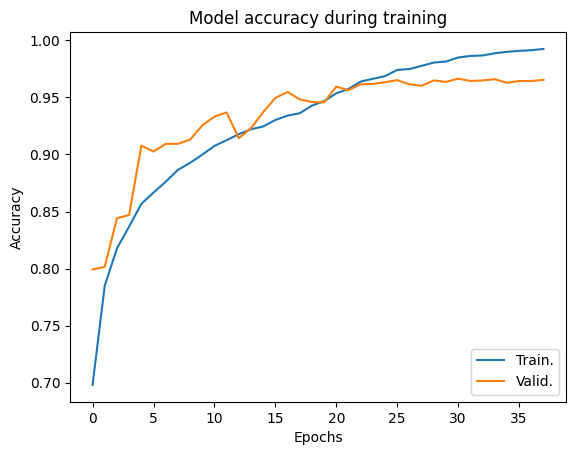

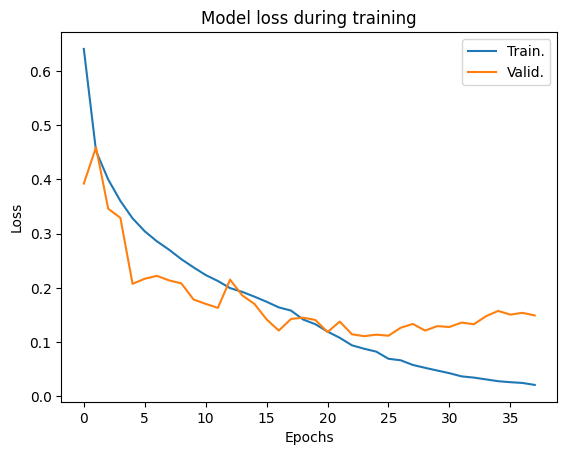

In [1217]:
import matplotlib.pyplot as plt
from keras.models import load_model
import numpy as np

model = load_model("vision_transformer_class.keras",
                   custom_objects={"TransformerEnconder": TransformerEncoder,
                                   "PatchEncoder": PatchEncoder})

print("Average loss and accuracy during training:")
print(f"loss: {np.average(history.history['loss']):.4f} - accuracy: {np.average(history.history['accuracy']) * 100:.2f}%")

print("Model validation:")
scores = model.evaluate(val_ds, verbose=0)
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train.', 'Valid.'], loc='lower right')
plt.show()

print("\n")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train.', 'Valid.'], loc='upper right')
plt.show()

# **Test metrics**

In [1218]:
scores = model.evaluate(test_ds, verbose=0)
print("Model testing:")
print(f'loss: {scores[0]:.4f} - accuracy: {scores[1]* 100:.2f}%')

Model testing:
loss: 0.0912 - accuracy: 97.17%


## Confusion matrix

In [1219]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(test_ds), axis=1) # Get predictions for the test dataset with shape (n_samples, n_classes)
                                                   # Takes the highest probability along the axis 1, wich means "for that sample, wich of these classes it belongs?"

y_true = np.concatenate([label.numpy() for image, label in test_ds], axis=0) # vertical stacking, creating only a vector with the labels

cm = confusion_matrix(y_true, y_pred)
cm

121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


array([[1875,   55],
       [  54, 1873]])

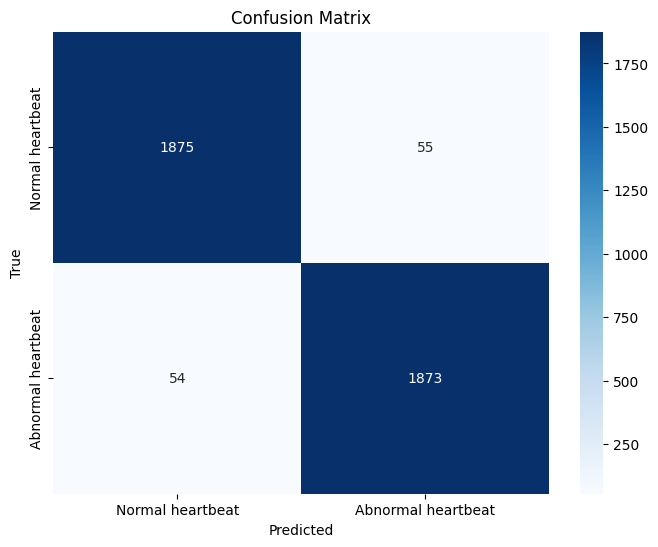

In [1220]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal heartbeat','Abnormal heartbeat'],
            yticklabels=['Normal heartbeat','Abnormal heartbeat'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [1221]:
import pandas as pd

report = classification_report(y_true, y_pred, target_names=['Normal heartbeat', 'Anormal heartbeat'],output_dict=True)
pd.DataFrame(report)

,Normal heartbeat,Anormal heartbeat,accuracy,macro avg,weighted avg
precision,0.972006,0.971473,0.97174,0.97174,0.97174
recall,0.971503,0.971977,0.97174,0.97174,0.97174
f1-score,0.971754,0.971725,0.97174,0.97174,0.97174
support,1930.000000,1927.000000,0.97174,3857.00000,3857.00000
